In [2]:
import os
import sys
import warnings
import math
import numpy as np
import pandas as pd
import platform
import re
import subprocess
import torch as th
import pickle
import gymnasium as gym
import matplotlib.pyplot as plt
from datetime import datetime
from scripts.utils import (
    load_scenario_data,
    verify_training_folders,
    create_results_directory,
    get_model_version,
    format_days,
    calculate_training_days,
    initialize_device,
    check_device_capabilities,
    get_device_info,
)
from scripts.visualizations import *
from src.config import *
from sb3_contrib import MaskablePPO
from stable_baselines3.common.logger import configure
from stable_baselines3.common.vec_env import DummyVecEnv
from sb3_contrib.common.wrappers import ActionMasker
from src.environment import AircraftDisruptionEnv
from sb3_contrib.common.maskable.utils import get_action_masks


LEARNING_RATE = 0.001
GAMMA = 0.99
BUFFER_SIZE = 50000 * 2
BATCH_SIZE = 64 * 4
TARGET_UPDATE_INTERVAL = 100
MAX_TIMESTEPS = 5000
NEURAL_NET_STRUCTURE = dict(net_arch=[256, 256 * 2, 256])
LEARNING_STARTS = 0
TRAIN_FREQ = 4
EPSILON_START = 1.0
EPSILON_MIN = 0.025
PERCENTAGE_MIN = 95
N_EPISODES = 5
TRAINING_FOLDERS_PATH = "../data/Training/3ac-10-deterministic/"

device = initialize_device()
check_device_capabilities()
device_info = get_device_info(device)
print(f"Device info: {device_info}")

training_folders = verify_training_folders(TRAINING_FOLDERS_PATH)
print(f"Training folders: {training_folders}")

num_days_trained_on = calculate_training_days(N_EPISODES, training_folders)
print(f"Training on {num_days_trained_on} days of data "
      f"({N_EPISODES} episodes of {len(training_folders)} scenarios)")

formatted_days = format_days(num_days_trained_on)
last_folder = os.path.basename(os.path.normpath(TRAINING_FOLDERS_PATH))
model_name = last_folder
model_version_myopic = get_model_version(model_name, myopic_proactive="myopic", drl_type="ppo")
model_version_proactive = get_model_version(model_name, myopic_proactive="proactive", drl_type="ppo")
MODEL_SAVE_PATH = f'../trained_models/ppo/'
MODEL_SAVE_NAME_MYOPIC = f'{model_name}-{formatted_days}-{model_version_myopic}.zip'
MODEL_SAVE_NAME_PROACTIVE = f'{model_name}-{formatted_days}-{model_version_proactive}.zip'
print(f"Models will be saved to:")
print(f"   {MODEL_SAVE_PATH}myopic_{MODEL_SAVE_NAME_MYOPIC}")
print(f"   {MODEL_SAVE_PATH}proactive_{MODEL_SAVE_NAME_PROACTIVE}")

results_dir = create_results_directory(append_to_name='ppo')
print(f"Results directory created at: {results_dir}")

global total_rewards_logging
total_rewards_logging = {}

def my_get_action_masks(env):
    # env is a single env at this point, so just directly call get_action_mask()
    mask = env.get_action_mask()
    # Ensure mask is a numpy array
    mask = np.array(mask, dtype=np.uint8)
    return mask



def train_ppo_agent(env_type):
    rewards = []
    total_timesteps = 0
    scenario_folders = [
        os.path.join(TRAINING_FOLDERS_PATH, folder)
        for folder in os.listdir(TRAINING_FOLDERS_PATH)
        if os.path.isdir(os.path.join(TRAINING_FOLDERS_PATH, folder))
    ]

    class ScenarioEnvWrapper(gym.Env):
        
        def __init__(self, scenario_folders, env_type):
            super(ScenarioEnvWrapper, self).__init__()
            self.scenario_folders = scenario_folders
            self.env_type = env_type
            self.current_scenario_idx = -1
            self.load_next_scenario()
            self.observation_space = self.env.observation_space
            self.action_space = self.env.action_space
            self.episode_reward = 0  # Track rewards in an episode
            self.total_rewards = []  # Store total rewards for analysis

        def load_next_scenario(self):
            self.current_scenario_idx = (self.current_scenario_idx + 1) % len(self.scenario_folders)
            scenario_folder = self.scenario_folders[self.current_scenario_idx]
            data_dict = load_scenario_data(scenario_folder)
            aircraft_dict = data_dict['aircraft']
            flights_dict = data_dict['flights']
            rotations_dict = data_dict['rotations']
            alt_aircraft_dict = data_dict['alt_aircraft']
            config_dict = data_dict['config']

            self.env = AircraftDisruptionEnv(
                aircraft_dict,
                flights_dict,
                rotations_dict,
                alt_aircraft_dict,
                config_dict,
                env_type=self.env_type
            )

        def reset(self, seed=None, options=None):
            # Log reward even if it's zero
            self.total_rewards.append(self.episode_reward)
            self.episode_reward = 0  # Reset episode reward
            self.load_next_scenario()
            obs, info = self.env.reset()
            return obs, info


        def step(self, action):
            output = self.env.step(action)
            if self.current_scenario_idx not in total_rewards_logging:
                total_rewards_logging[self.current_scenario_idx] = []
            total_rewards_logging[self.current_scenario_idx].append(output[1])

            self.episode_reward += output[1]  # Accumulate reward
            if output[2] or output[3]:
                self.total_rewards.append(self.episode_reward)
                self.episode_reward = 0
            return output

        def render(self, mode='human'):
            return self.env.render(mode=mode)

        def close(self):
            return self.env.close()

        def get_action_mask(self):
            return self.env.get_action_mask()

    env = ScenarioEnvWrapper(scenario_folders, env_type)
    env = ActionMasker(env, my_get_action_masks)  # Wrap the single env first
    env = DummyVecEnv([lambda: env])              # Now vectorize



    model = MaskablePPO(
        'MultiInputPolicy',
        env,
        learning_rate=LEARNING_RATE,
        gamma=GAMMA,
        verbose=1,
        tensorboard_log=f"./ppo_aircraft_tensorboard_{env_type}/",
        device=device,
        policy_kwargs=NEURAL_NET_STRUCTURE,
    )

    logger = configure()
    model.set_logger(logger)

     # Custom function to log rewards
    def log_rewards(_locals, _globals):
        original_env = _locals['self'].env.get_attr('env')[0]
        if isinstance(original_env, ScenarioEnvWrapper):
            total_rewards = original_env.total_rewards
            if total_rewards:
                recent_rewards = total_rewards[-len(total_rewards):]
                logger.record('rollout/ep_rew_mean', np.mean(recent_rewards))
                logger.record('rollout/ep_rew_std', np.std(recent_rewards))
        return True


    
    model.learn(total_timesteps=MAX_TIMESTEPS, use_masking=True, callback=log_rewards)


    if env_type == "myopic":
        model.save(f"{MODEL_SAVE_PATH}myopic_{MODEL_SAVE_NAME_MYOPIC}")
    else:
        model.save(f"{MODEL_SAVE_PATH}proactive_{MODEL_SAVE_NAME_PROACTIVE}")
    return rewards, total_timesteps

start_time = datetime.now()
results_myopic = train_ppo_agent('myopic')
results_proactive = train_ppo_agent('proactive')
rewards_myopic, total_timesteps_myopic = results_myopic
rewards_proactive, total_timesteps_proactive = results_proactive

myopic_rewards_file = os.path.join(results_dir, "rewards_myopic.pkl")
with open(myopic_rewards_file, "wb") as file:
    pickle.dump(rewards_myopic, file)
print(f"Myopic rewards saved to {myopic_rewards_file}")

proactive_rewards_file = os.path.join(results_dir, "rewards_proactive.pkl")
with open(proactive_rewards_file, "wb") as file:
    pickle.dump(rewards_proactive, file)
print(f"Proactive rewards saved to {proactive_rewards_file}")

end_time = datetime.now()
runtime = (end_time - start_time).total_seconds()
print(f"Total training time: {runtime} seconds")


Using device: mps
CUDA available: False
Number of GPUs available: 0
cuDNN enabled: True
Device: mps
Using MacBook M1
Device info: {'device_type': 'MacBook M1'}
Training folders: ['Scenario_03', 'Scenario_04', 'Scenario_05', 'Scenario_02', 'Scenario_10', 'Scenario_09', 'Scenario_07', 'Scenario_01', 'Scenario_06', 'Scenario_08']
Training on 50 days of data (5 episodes of 10 scenarios)
Getting model version for 3ac-10-deterministic
Getting model version for 3ac-10-deterministic
Models will be saved to:
   ../trained_models/ppo/myopic_3ac-10-deterministic-50-1.zip
   ../trained_models/ppo/proactive_3ac-10-deterministic-50-1.zip
Results directory created at: ../results/ppo/20241205-23-09
Using mps device
Logging to /var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/SB3-2024-12-05-23-09-12-364086
----------------------------------
| rollout/           |           |
|    ep_rew_mean     | -1.88e+03 |
|    ep_rew_std      | 1e+04     |
| time/              |           |
|    fps             | 15

In [ ]:
# Plot total rewards over time using the existing total_rewards_logging
plt.figure(figsize=(10, 5))
for scenario_idx, rewards in total_rewards_logging.items():
    plt.plot(rewards, label=f'Scenario {scenario_idx}')
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title('Total Rewards Over Episodes')
plt.legend()
plt.grid()
plt.show()



Available columns in the log file: Index(['rollout/ep_rew_mean', 'time/iterations', 'time/fps',
       'time/total_timesteps', 'time/time_elapsed', 'rollout/ep_rew_std',
       'train/value_loss', 'train/entropy_loss', 'train/n_updates',
       'train/approx_kl', 'train/learning_rate', 'train/explained_variance',
       'train/clip_fraction', 'train/loss', 'train/policy_gradient_loss',
       'train/clip_range'],
      dtype='object')
0   -2658.292461
1   -1970.889896
2   -1723.368022
Name: rollout/ep_rew_mean, dtype: float64


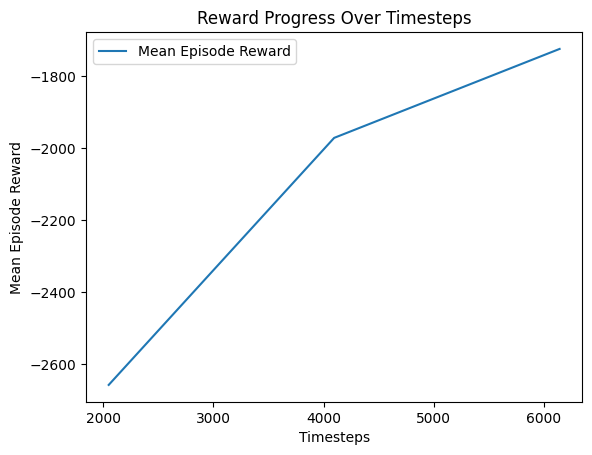

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Replace this with the actual log directory path from the notification
log_dir = "/var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/SB3-2024-12-05-22-57-16-898126"
log_file = os.path.join(log_dir, "progress.csv")

# Check if the log file exists
if not os.path.exists(log_file):
    raise FileNotFoundError(f"Log file not found: {log_file}")

# Load the CSV file
df = pd.read_csv(log_file)

# Inspect the available columns
print("Available columns in the log file:", df.columns)
print(df['rollout/ep_rew_mean'])
# Plot total rewards over time
if 'rollout/ep_rew_mean' in df.columns:
    plt.plot(df['time/total_timesteps'], df['rollout/ep_rew_mean'], label='Mean Episode Reward')
    plt.xlabel('Timesteps')
    plt.ylabel('Mean Episode Reward')
    plt.title('Reward Progress Over Timesteps')
    plt.legend()
    plt.show()
else:
    print("Column 'rollout/ep_rew_mean' not found in the log file.")
